# Data processing for global correlation wavefield

This is the Jupyter notebook in supplement to the main article in Earth-Science Reviews *The Earth's coda correlation wavefield: Rise of the new paradigm and recent advances*.

Please cite at least of one of the following article if you use a part or entire code in your research:
- H. Tkalčić, T.-S. Phạm and S. Wang, The Earth's coda correlation wavefield: Rise of the new paradigm and recent advances, Earth-Science Reviews, 208, doi:10.1016/j.earscirev.2020.103285, 2020.

- Phạm T.-S., H. Tkalčić, M. Sambridge, and B. L. N. Kennett, Earth's correlation wavefield: Late coda correlation, Geophys. Res. Lett., 45 (7),  doi:10.1002/2018GL077244, 2018.

- Tkalčić, H. and T.-S. Phạm, Shear properties of the Earth's inner core revealed by a detection of J waves in global correlation wavefield, Science, 362, doi:10.1126/science.aau7649, 2018.

Canberra, July 2020  
*Dr T. Son Pham*  
thanhson.pham@anu.edu.au

## Download data from the Global Seismograph Network for an event of interest

In [1]:
# !pip install obspy
!pip install numpy==1.24.1

In [3]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from pathlib import Path
from obspy import read_events, read_inventory, read
from obspy.geodetics import locations2degrees
import pickle


def get_event(eventid):
    """
    Get the origin time of an event given its event ID.
    """
    # file name for the event information
    fname = Path(f'ISC.{eventid}.xml')
    # Download the event information from ISC if not already downloaded
    if not fname.exists():
        event = Client('ISC').get_events(eventid=eventid, filename=fname)
    # Read the event information from the file
    event = read_events(fname)[0]
    return event

def get_waveform_data(event_origin):
    eventtime = event_origin.time
    evla = event_origin.latitude
    evlo = event_origin.longitude
    # search for all stations in the _GNS network recording in the time window
    inv_fname = Path(eventtime.strftime('GSN.%Y%m%d%H%M%S.staxml'))
    # Download the station information from IRIS if not already downloaded
    if not inv_fname.exists():
        Client().get_stations(network="_GSN", starttime=eventtime, endtime=eventtime+24*3600, level='channel', filename=inv_fname)
    # Read the station information from the file
    inv = read_inventory(inv_fname)

    # for each station, add a line to the bulk request depending on their location code
    loc_priorities = ['', '00', '10']
    bulk = []
    for net in inv:
        for sta in net:
            loc_codes = [cha.location_code for cha in sta.channels]
            if len(set(loc_priorities) & set(loc_codes)) == 0: continue
            # get the location code with the highest priority
            for loccode in loc_priorities:
                if loccode in loc_codes: break
            # add the bulk entry
            bulk.append((net.code, sta.code, loccode, 'BHZ', eventtime+5e3, eventtime+40e3))
    print (f'Found {len(bulk)} stations in the GSN network')

    # Download the waveforms from IRIS if not already downloaded
    pkl_fname = Path(eventtime.strftime('GSN.%Y%m%d%H%M%S.pkl'))
    if not pkl_fname.exists():
        print ('Downloading waveforms ...')
        dstream = Client().get_waveforms_bulk(bulk, longestonly=True, minimumlength=7*3600, attach_response=True)
        print (dstream)
        with open(pkl_fname, 'wb') as f: pickle.dump(dstream, f)
    else: # Read the waveforms from the file
        print ('Reading waveforms ...')
        with open(pkl_fname, 'rb') as f: dstream = pickle.load(f)
    # Remove the instrument response
    print ('Removing instrument response ...')
    dstream.remove_response(output="VEL")
    # Add station coordinates to the trace
    for tr in dstream:
        tmp = inv.select(network=tr.stats.network, station=tr.stats.station)[0][0]
        tr.stats.update({'stla': tmp.latitude, 'stlo': tmp.longitude,
            'distance': locations2degrees(evla, evlo, tmp.latitude, tmp.longitude)*111.195e3})
    return dstream

event = get_event("611831635")

dstream = get_waveform_data(event.preferred_origin())
dstream.resample(1.0)

# from obspy import Stream, read
# from pathlib import Path
# dstream1 = Stream()
# for fname in Path('ESR_CorrelationWavefield/Data/Event_2017.01.22.04.30.22.990').glob('*.SAC'):
#     dstream1 += read(fname)
# for tr in dstream1:
#     tr.stats.update({'stla': tr.stats.sac.stla, 'stlo': tr.stats.sac.stlo,
#         'distance': locations2degrees(event.preferred_origin().latitude, event.preferred_origin().longitude,
#             tr.stats.sac.stla, tr.stats.sac.stlo)*111.195e3})
# idx = np.random.choice(len(dstream1), 500, replace=False)
# dstream = Stream([dstream1[i] for i in idx])
# dstream.resample(1.0)

## preprocess the data
dstream.detrend('linear')
dstream.taper(max_percentage=0.01, type='cosine')
dstream.trim(event.preferred_origin().time+10e3, event.preferred_origin().time+35e3, pad=True, fill_value=0)


Found 205 stations in the GSN network
Reading waveforms ...


ModuleNotFoundError: No module named 'numpy._core'

/Users/thanhson/.pyenv/versions/emcee/lib/python3.11/site-packages/obspy/imaging/waveform.py:1354: RuntimeWarning: invalid value encountered in divide
  data = ((self._tr_data[_tr] / self._tr_normfac[_tr] *


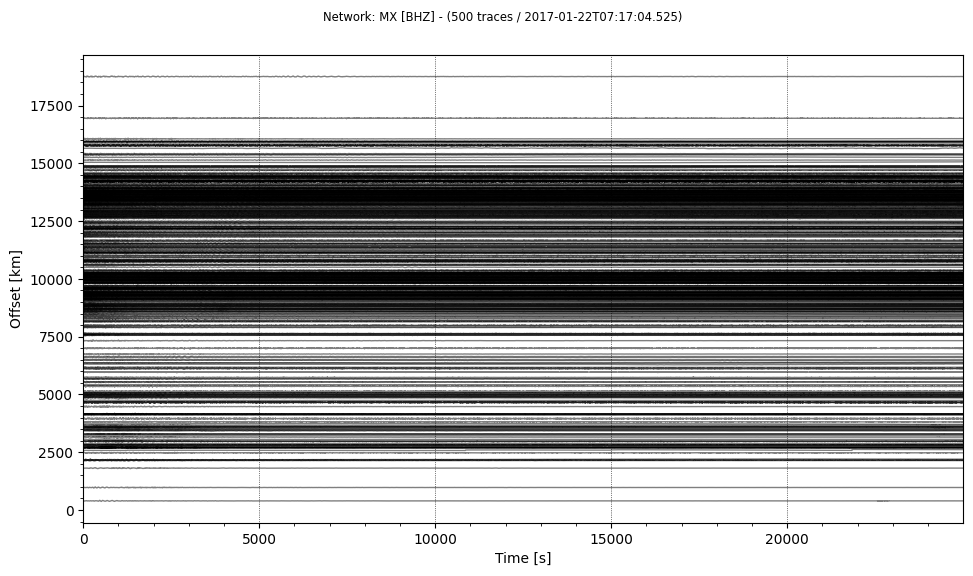

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dstream.plot(type='section', orientation='horizontal',
            #  time_window=7*3600,
             color='black',
             show=True)

plt.show()

In [ ]:
# %load_ext autoreload
# %autoreload 2

---
## Single station processing

- Temporal normalization

- Spectral normalization

Here we demonstrate how the running absolute mean normalization work in the time domain.

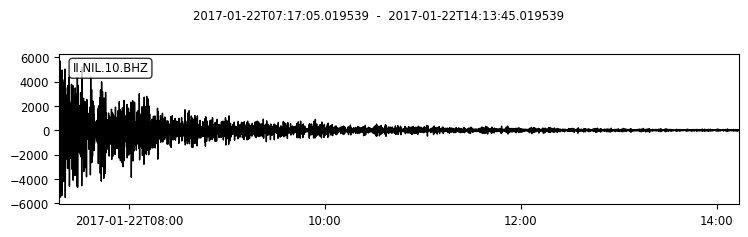

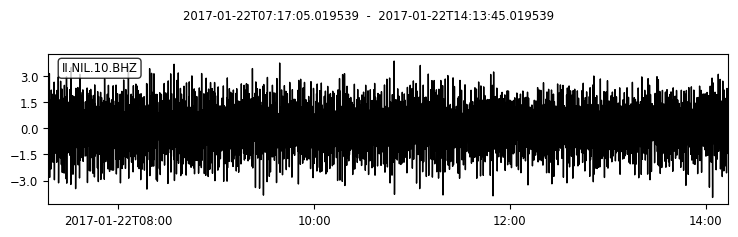

In [ ]:
from obspy import Trace, Stream
import numpy as np

def running_absolute_mean_normalization(input_tr, width, fband=None):
    """
    Apply running absolute mean normalization to a waveform/spectral trace.
    :param trace: ObsPy Trace object
    :param fband: frequency band for the filter / None if no pre-filtering is applied to the weight
    :param width: width of the running absolute mean normalization window in seconds or Hz depending on the input_tr
    :return: output_tr trace
    """
    if type(input_tr) is not Trace:
        raise TypeError('Input trace is not an ObsPy Trace object.')
    # pre-filter the weight trace if frequency filter band is given
    weight_tr = input_tr.copy()
    output_tr = input_tr.copy()
    if type(input_tr.data[0]) is np.complex128 or type(input_tr.data[0]) is np.complex64:
        delta = input_tr.stats.delta_f
    else:
        delta = input_tr.stats.delta
    # convert width to sample points
    if fband is not None:
        weight_tr.filter('bandpass', freqmin=fband[0], freqmax=fband[1], corners=4, zerophase=True)
    # calculate the normalizing weight by running absolute mean
    winlen = 2 * int(0.5 * width / delta) + 1
    avg_mask = np.ones(winlen) / winlen
    weight = np.convolve(np.abs(weight_tr.data), avg_mask, 'same')
    # divide the orignal data by the smoothed weight
    mask = (weight > 1e-8*np.max(weight))
    output_tr.data[mask] = input_tr.data[mask] / weight[mask]
    output_tr.data[np.logical_not(mask)] = 0
    # taper the trace by 1% cosine taper
    # output_tr.taper(type='cosine', max_percentage=0.01) # inplace
    # return the output_tr trace
    return output_tr

# apply running absolute mean normalization to the data
input_tr = dstream[0].copy()

tmp = input_tr.copy().filter('bandpass', freqmin=0.02, freqmax=0.067, corners=4, zerophase=True)
tmp.plot()

output_tr = running_absolute_mean_normalization(input_tr, 128, fband=[0.02, 0.067])

tmp = output_tr.copy().filter('bandpass', freqmin=0.02, freqmax=0.067, corners=4, zerophase=True)
tmp.plot()

plt.show()

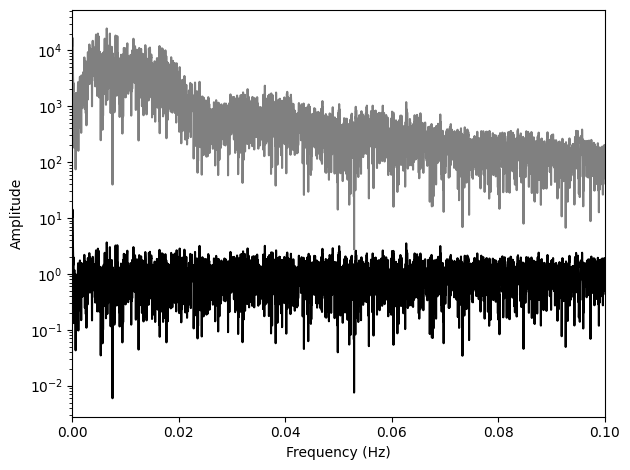

In [ ]:
from scipy.fftpack import next_fast_len
def spectral_normalization(input_tr, npts, ram_width):
    """
    Apply spectral normalization to a waveform trace.
    :param input_tr: ObsPy Trace object
    :param npts: number of points for FFT
    :param ram_width: width of the running absolute mean normalization window in seconds
    :return: output_tr trace
    """
    # get the number of points for FFT using tensorflow fft module
    fft_npts = next_fast_len(2*npts)
    # real-to-complex FFT by numpy
    spec_data = np.fft.rfft(input_tr.data, fft_npts)
    # create a spectral trace
    spec_tr = Trace(data=spec_data, header=input_tr.stats)
    spec_tr.stats.update({'npts':len(spec_data), 'delta_f':.5/((len(spec_data)-1)*input_tr.stats.delta)})
    # apply running absolute mean normalization to the spectral trace
    if ram_width is not None:
        return running_absolute_mean_normalization(spec_tr, ram_width)
    else:
        return spec_tr

# apply spectral normalization to the data
spec_tr = spectral_normalization(output_tr, 7*3600, 2e-3)
spec_tr0 = spectral_normalization(output_tr, 7*3600, None)
fig, ax = plt.subplots()
freqs = np.arange(spec_tr.stats.npts) * spec_tr.stats.delta_f
ax.semilogy(freqs, np.abs(spec_tr.data), color='black')
ax.semilogy(freqs, np.abs(spec_tr0.data), color='gray')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_xlim([0, 0.1])
fig.tight_layout()
plt.show()

Let's see the effect of each processing step on a single waveforms

In [ ]:
spec_st = Stream()
for data_tr in dstream:
    temp_tr = running_absolute_mean_normalization(data_tr, 128, fband=[0.02, 0.067])
    spec_tr = spectral_normalization(temp_tr, 7*3600, 2e-3)
    spec_st.append(spec_tr)

---
## Station pair cross-correlation

We use the spectral data obtained from this step to perform cross-correlation. It involve the multiplication of one spectra to the conjugate of the others.

As the number of operation is O (N^2), increase as squared of cross-correlation function. The cell below show the principle of this processing step, which is optimized later to run in many station.

In [ ]:
from obspy.geodetics import locations2degrees
from concurrent.futures import ThreadPoolExecutor
import threading

def xcorr_stack(spec_st, dist_bins, max_tlag, ncores=2):
    '''
    Calculates the cross-correlation function of the given spectral data. Run the jobs
    on a GPU device if available, otherwise, run on CPU using threading.

    Args:
        spec_data (ndarray): The spectral data, represented as a complex numpy array.
        nbins (int): The number of cross-correlation distance bins.
        cc_inds (ndarray): The indices of the cross-correlation bins.

    Returns:
        ndarray: The cross-correlation function in the time domain.
    '''
    stlats = [tr.stats.stla for tr in spec_st]
    stlons = [tr.stats.stlo for tr in spec_st]
    spec_data = np.array([tr.data for tr in spec_st])
    # number of traces and frequency bins
    ntraces, nspec = spec_data.shape
    # number of cross-correlation distance bins
    nbins = len(dist_bins) - 1
    # global variables
    spec_xcorr_stack = np.zeros([nbins, nspec], dtype=np.complex128)
    bin_count = np.zeros(nbins, dtype=np.float32)

    # calculate all inter-receiver distances
    mlats, mlons = np.meshgrid(stlats, stlons)
    cc_gcarc = locations2degrees(mlats, mlons, mlats.T, mlons.T)
    # determine the bin index for each inter-receiver distance
    cc_inds = np.digitize(cc_gcarc, dist_bins) - 1

    # Create a lock for each bin
    # Note: the multiple locks for each bin is recommended to avoid congested
    # memory access when multiple threads are trying to access the same bin.
    locks = [threading.Lock() for _ in range(nbins)]

    # Create a ThreadPoolExecutor
    with ThreadPoolExecutor(ncores) as executor:
        # Local cross-correlation function to excecuted in multiple threads
        def cross_correlation(s1):
            # Cross-correlation function in frequency domain
            spec_xcorr = spec_data[s1] * np.conj(spec_data[s1:])
            for _, ind in enumerate(cc_inds[s1, s1:]):
                # Acquire the lock for stacking
                with locks[ind]:
                    # Bin pair cross-correlograms in frequency domain
                    spec_xcorr_stack[ind] += spec_xcorr[_]
                    # Count the trace pairs in each inter-receiver bin
                    bin_count[ind] += 1

        # Run the cross-correlation function in a separate thread
        for s1 in range(ntraces):
            executor.submit(cross_correlation, s1)

    # inverse FFT to get the cross-correlation function in time domain
    corrwf = np.fft.irfft(spec_xcorr_stack)
    # fold the cross-correlation function and trim the time window
    nmaxlag = int(max_tlag / spec_st[0].stats.delta)
    corrwf = 0.5 * (corrwf + corrwf[:, ::-1])[:, :nmaxlag]

    return corrwf, bin_count

dist_bins = np.linspace(0, 180, 181)
corrwf, bin_count = xcorr_stack(spec_st, dist_bins, 4000, ncores=None)

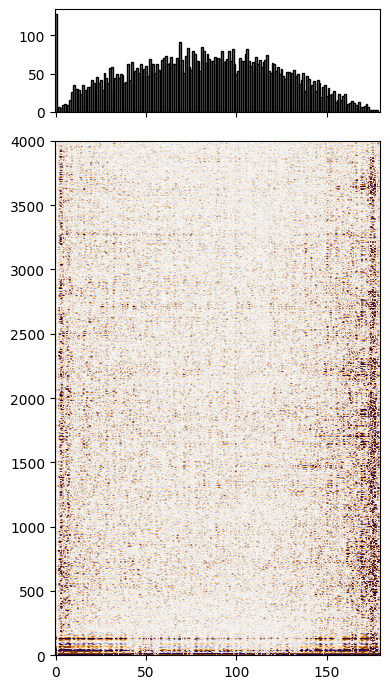

In [ ]:
from obspy.signal.filter import bandpass
img = corrwf.copy()
delta = spec_st[0].stats.delta
for i in range(img.shape[0]):
    if bin_count[i] == 0: continue
    img[i] /= bin_count[i]
    img[i] = bandpass(img[i], freqmin=0.02, freqmax=0.067, corners=4, zerophase=True, df=1/delta)

fig, ax = plt.subplots(2, 1, figsize=(4, 7), sharex=True, gridspec_kw={'height_ratios': (.2, 1.)})
VMAX = 2e-2 * np.max(np.abs(img))
ax[0].bar(np.arange(len(bin_count)), bin_count, width=1, color='gray', edgecolor='black')
ax[1].imshow(img.T, aspect='auto', vmin=-VMAX, vmax=VMAX, cmap='PuOr', origin='lower', interpolation='sinc')
ax[1].set(ylim=(0, 4000))
fig.tight_layout()
plt.show()

Let's see the demonstration.

Now we put all together for to compute the cross-correlation function selected earthquakes.

When you run this cell, the output file will be sent to my cloud directory. Please refer to my screen for the results.